# Visualisation and Verbalisationfor Explainable AI (XAI)

## INM363 Individual Project
City, University of London
MSc in Data Science

Student Name: Heiko Maerz, heiko.maerz@city.ac.uk

Supervisor: Dr Cagatay Turkay

By submitting this work, I declare that this work is entirely my own except those parts duly identified and referenced in my submission. It complies with any specified word limits and the requirements and regulations detailed in the assessment instructions and any other relevant programme and module documentation. In submitting this work, I acknowledge that I have read and understood the regulations and code regarding academic misconduct, including that relating to plagiarism, as specified in the Programme Handbook. I also acknowledge that this work will be subject to a variety of checks for academic misconduct.

### This Jupyter notebook is used to:

pre-process the data, <br>
train and evaluate the ML models, <br>
experiment with dimensionality reduction to find clusters in the data <br>
run a first prototype of Bokeh, <br>
run and evaluate both SHAP and LIME explainer, and <br>
pre-compute the counterfactuals.

In [1]:
# switches and flags
run_bokeh = True 

# switch off warnings
if False:
    import warnings
    warnings.filterwarnings('ignore')

# optimise output
# source: https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
if False:
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>")) 

# imports
if run_bokeh:
    import bokeh
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool
    from bokeh.models.annotations import Span
    from bokeh.plotting import figure
import datetime
import itertools
import joblib
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap
import sklearn
from sklearn.decomposition import KernelPCA, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import sys

# and my own utilities
import XAi_Utilities as utls

# very coarse time-keeping and debugging
def print_timestamp(desc = 'n/a'):
    """print a status message and time stamp (hour:minute:second)"""
    print(f"{desc} at {datetime.datetime.now().strftime('%H:%M:%S')}")
          
# switches and flags
run_bokeh = True 
# the task is not to find the best model to generalise, 
# for that reason there is no train and test split          
train_test = False
pd.options.display.max_columns = None 
          

In [2]:
# versions, for the readme
if True:
    print(f"Python version {sys.version}\n")
    if run_bokeh:          
        print(f"bokeh=={bokeh.__version__}")  
    print(f"datetime")
    print(f"itertools") #=={itertools.__version__}")
    print(f"joblib=={joblib.__version__}")
    print(f"lime") #=={lime.__version__}") 
    print(f"matplotlib=={matplotlib.__version__}")
    print(f"numpy=={np.__version__}")
    print(f"seaborn=={sns.__version__}")
    print(f"shap=={shap.__version__}") 
    print(f"sklearn=={sklearn.__version__}")
    print(f"os")
    print(f"pandas=={pd.__version__}")
    print(f"seaborn=={sns.__version__}")
    print(f"sys")

Python version 3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]

bokeh==1.3.4
datetime
itertools
joblib==0.13.2
lime
matplotlib==3.1.1
numpy==1.17.1
seaborn==0.9.0
shap==0.29.3
sklearn==0.21.3
os
pandas==0.25.1
seaborn==0.9.0
sys


# Import and Pre-Process the Data


In [3]:
# setup file paths
# the following paths must exist in the directory of this Jupyter notebook
data_path = os.path.join(os.getcwd(), 'data') # read and write data
image_path = os.path.join(os.getcwd(), 'images') # write graphviz .DOT files and images
model_path = os.path.join(os.getcwd(), 'models') # save models

print(f"data  : '{data_path}'")
print(f"images: '{image_path}'")
print(f"models: '{model_path}'")


data  : '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/data'
images: '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/images'
models: '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/models'


In [4]:
# load data

# this function loads the Fifa data file
#     handling of missing data:
#     - '1st Goal' and 'Own goal time' dropped,
#     - 'Own goals set to 0
#     copy the numerical data into features dataframe
#     copy label into labels dataframe
fifa_features, fifa_labels = utls.load_fifa_data(data_path, 'FIFA 2018 Statistics.csv')

print(f"feature shape:{fifa_features.shape}\nlabel shape:{fifa_labels.shape}\n")
fifa_features.head()


feature shape:(128, 19)
label shape:(128, 1)



,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0,0.0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0,0.0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0,0.0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0,0.0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0,1.0


In [5]:
# show some statistics
fifa_features.describe()


,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,1.343750,14.890625,2.726562,82.554688,462.648438,106.664062,13.546875,1.695312,0.015625,0.015625,0.203125,0.093750
std,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,1.193404,4.724262,2.049447,5.933766,151.186311,11.749537,4.619131,1.325454,0.124507,0.124507,0.807049,0.292626
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,67.000000,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,79.000000,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,83.000000,462.000000,104.500000,13.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,2.000000,18.000000,4.000000,87.000000,555.250000,109.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,94.000000,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,4.000000,1.000000


## Columns in the original dataset
Data source: https://www.kaggle.com/mathan/fifa-2018-match-statistics

### Columns
Date: Match Date <br>
Team: Playing Team <br>
Opponent: Opponent Team <br>
Goal Scored: Number of goals scored by this team <br>
Ball Possession %: Amount of time ball was in control by the team <br>
Attempts: Number of attempts to score goal <br>
On-Target: Number of shots on-target <br> 
Off-Target: Number of shots that went off-target <br>
Blocked: Number of opponent team's attempts blocked by the team <br>
Corners: Number of corner shots used <br>
Offsides: Number of off-side events <br>
Free Kicks: Number of free-kicks used <br>
Saves: Number saves by the goal keeper <br>
Pass Accuracy %: Percentage of passes that reached the same team player as aimed <br>
Passes: Total number of passes by the team <br>
Distance Covered (Kms): Total distance covered by the team members in this game <br>
Fouls Committed: Number of fouls committed by the team members <br>
Yellow Card: Number of Yellow warning received <br>
Yellow & Red: Number of Yellow & Red warning received <br>
Red: Number of Red cards received <br>
Man of the Match: Did this team member win Man of the Match? <br>
1st Goal: When did the team score the 1st goal? <br>
Round: Stage of the match <br>
PSO: Was there a penalty shootout (PSO) in this match? <br>
Goals in PSO: Number of goals scored in the Penalty shootout <br>
Own goals: Number of own goals <br>
Own goal Time: When did the team score own goal? <br>

In [6]:
# data about the labels
print(f"unique labels: {fifa_labels['Man of the Match'].unique()}")
print(f"label distribution:\n{fifa_labels['Man of the Match'].value_counts()}")
      

unique labels: [1 0]
label distribution:
1    64
0    64
Name: Man of the Match, dtype: int64


In [7]:
# the task is not to find the best model to generalise, 
# for that reason there is no train and test split
if train_test:
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split( fifa_features
                                                       , fifa_labels
                                                       , test_size = test_size
                                                       , random_state=42
                                                       , stratify = fifa_labels)
else:
    X_train = fifa_features.copy()
    y_train = fifa_labels.copy()

# re-load the entire data-set and normalise numeric features
def normalise_features(norm=False):
    if norm:
        X_train = utls.normalise_numeric(fifa_features.copy())
        y_train = fifa_labels.copy() 
    else:
        X_train = fifa_features.copy()
        y_train = fifa_labels.copy()
    return X_train, y_train

# save models and calculate accuracy and f1-score
def save_and_evaluate_model(trained_model, model_name):
    # saves a model with joblib
    path, fname = utls.save_model(trained_model, model_name, 'SKLearn', 'fifa', compress=9) 
    print(f"model {model_name} saved as {fname}")

    # training accuracy
    acc_train, fl_train, cm_train = utls.text_acc_f1_cm( X_train 
                                                       , y_train
                                                       , trained_model
                                                       , f'training score {model_name}')
    return acc_train, fl_train, cm_train

# calculate model accuracy and f1-score
def evaluate_model(trained_model, model_name):
    # accuracy training
    acc_train, fl_train, cm_train = utls.text_acc_f1_cm( X_train 
                                                       , y_train
                                                       , trained_model
                                                       , f'training score {model_name}')
    return acc_train, fl_train, cm_train


# Train Decision Trees
Decision Tree is used as the interpretable model,
train trees with maximum depth of 5, 7, and 9

## Decision Tree Depth 5

In [8]:
# use raw or scaled data
X_train, y_train = normalise_features(False)

# log start
print_timestamp('decision tree 5') 

# max depth 5 
# perform grid search to train a decision tree with maximum depth
# hyperparameters: { 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'] }
# NOTE: SKLearn GridSearchCV Number of jobs to run in parallel is set to -3
decision_tree5_gs = utls.train_decision_tree_mdepth(  X_train
                                                    , y_train.values.ravel()
                                                    , 5)
# use the best tree
decision_tree5 = decision_tree5_gs.best_estimator_

# grid search results, save tree model
print(f"best parameters: {decision_tree5_gs.best_params_}\n")
acc_train_dt5, f1_train_dt5, cm_train_dt5 = save_and_evaluate_model( decision_tree5
                                                                   , 'dec_tree_5')
print(f"{acc_train_dt5}\n{f1_train_dt5}\nconfusion matrix:\n{cm_train_dt5}\n")

# log end
print_timestamp('end')


decision tree 5 at 04:42:05
best parameters: {'criterion': 'gini', 'splitter': 'best'}

model dec_tree_5 saved as fifa_skl_dec_tree_5.pkl
accuracy for training score dec_tree_5 =  88.28%
f1-score for training score dec_tree_5 =  88.89%
confusion matrix:
[[53 11]
 [ 4 60]]

end at 04:42:07


In [9]:
decision_tree5 = DecisionTreeClassifier( random_state = 42
                                        , class_weight='balanced'
                                        , max_depth = 5
                                        , **decision_tree5_gs.best_params_)
decision_tree5.fit(X_train, y_train.values.ravel())
acc_train_dt5, f1_train_dt5, cm_train_dt5 = evaluate_model( decision_tree5
                                                                   , 'dec_tree_5')
print(f"{acc_train_dt5}\n{f1_train_dt5}\nconfusion matrix:\n{cm_train_dt5}\n")

accuracy for training score dec_tree_5 =  88.28%
f1-score for training score dec_tree_5 =  88.89%
confusion matrix:
[[53 11]
 [ 4 60]]



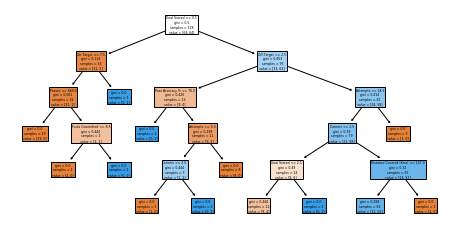

In [10]:
# plot the tree
plt.figure(figsize=(8, 4))
a = plot_tree(decision_tree5
             , feature_names = list(X_train.columns.values)
             , filled=True)
plt.show()


In [11]:
# GraphViz file for label encoded categorical attributes
# Export as dot file, display in http://www.webgraphviz.com/

fname = f"gvz_dec_tree_5_dot.txt";
fname = os.path.join(image_path,fname)
export_graphviz(decision_tree5, 
                out_file=fname, 
                feature_names = list(X_train.columns.values),
                class_names = ['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
print(f"copy and paste data from file '{fname}' \ninto http://www.webgraphviz.com/")


copy and paste data from file '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/images/gvz_dec_tree_5_dot.txt' 
into http://www.webgraphviz.com/


# Decision Tree - Max Depth 7

In [12]:
# use raw or scaled data
X_train, y_train = normalise_features(False)

# log start
print_timestamp('decision tree 7') 

# max depth 7
# perform grid search to train a decision tree with maximum depth
# hyperparameters: { 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'] }
# NOTE: SKLearn GridSearchCV Number of jobs to run in parallel is set to -3
decision_tree7_gs = utls.train_decision_tree_mdepth(  X_train
                                                    , y_train.values.ravel()
                                                    , 7)
# use the best tree
decision_tree7 = decision_tree7_gs.best_estimator_

# grid search results, save tree model
print(f"best parameters: {decision_tree7_gs.best_params_}\n")
acc_train_dt7, f1_train_dt7, cm_train_dt7 = save_and_evaluate_model( decision_tree7
                                                                   , 'dec_tree_7')
print(f"{acc_train_dt7}\n{f1_train_dt7}\nconfusion matrix:\n{cm_train_dt7}\n")

# log end
print_timestamp('end')


decision tree 7 at 04:42:08
best parameters: {'criterion': 'gini', 'splitter': 'best'}

model dec_tree_7 saved as fifa_skl_dec_tree_7.pkl
accuracy for training score dec_tree_7 =  92.97%
f1-score for training score dec_tree_7 =  93.13%
confusion matrix:
[[58  6]
 [ 3 61]]

end at 04:42:08


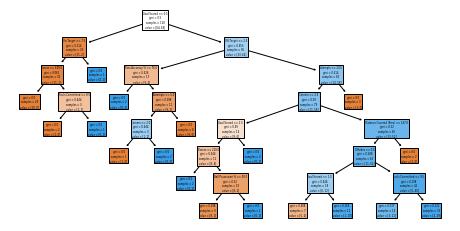

In [13]:
# plot the tree
plt.figure(figsize=(8, 4))
a = plot_tree(decision_tree7
             , feature_names = list(X_train.columns.values)
             , filled=True)
plt.show()


In [14]:
# GraphViz file for label encoded categorical attributes
# Export as dot file, display in http://www.webgraphviz.com/

fname = f"gvz_dec_tree_7_dot.txt";
fname = os.path.join(image_path,fname)
export_graphviz(decision_tree7, 
                out_file=fname, 
                feature_names = list(X_train.columns.values),
                class_names = ['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
print(f"copy and paste data from file '{fname}' \ninto http://www.webgraphviz.com/")


copy and paste data from file '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/images/gvz_dec_tree_7_dot.txt' 
into http://www.webgraphviz.com/


# Decision Tree - Max Depth 9

In [15]:
# use raw or scaled data
X_train, y_train = normalise_features(False)

# log start
print_timestamp('decision tree 9') 

# max depth 9
# perform grid search to train a decision tree with maximum depth
# hyperparameters: { 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'] }
# NOTE: SKLearn GridSearchCV Number of jobs to run in parallel is set to -3
decision_tree9_gs = utls.train_decision_tree_mdepth(  X_train
                                                    , y_train.values.ravel()
                                                    , 9)
# use the best tree
decision_tree9 = decision_tree9_gs.best_estimator_

# grid search results and save the model
print(f"best parameters: {decision_tree9_gs.best_params_}\n")
acc_train_dt9, f1_train_dt9, cm_train_dt9 = save_and_evaluate_model( decision_tree9
                                                                   , 'dec_tree_9')
print(f"{acc_train_dt9}\n{f1_train_dt9}\nconfusion matrix:\n{cm_train_dt9}\n")

# log end
print_timestamp('end')


decision tree 9 at 04:42:10
best parameters: {'criterion': 'gini', 'splitter': 'best'}

model dec_tree_9 saved as fifa_skl_dec_tree_9.pkl
accuracy for training score dec_tree_9 =  98.44%
f1-score for training score dec_tree_9 =  98.44%
confusion matrix:
[[63  1]
 [ 1 63]]

end at 04:42:10


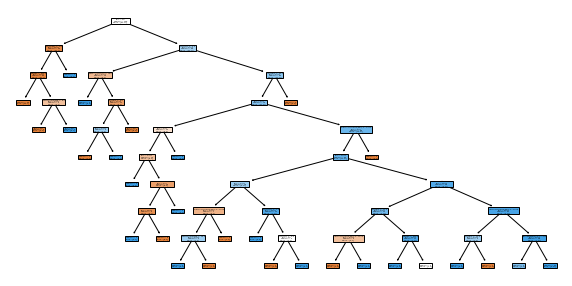

In [16]:
# plot the tree
plt.figure(figsize=(10, 5))
a = plot_tree(decision_tree9
             , feature_names = list(X_train.columns.values)
             , filled=True)
plt.show()


In [17]:
# GraphViz file for label encoded categorical attributes
# Export as dot file, display in http://www.webgraphviz.com/

fname = f"gvz_dec_tree_9_dot.txt";
fname = os.path.join(image_path,fname)
export_graphviz(decision_tree9, 
                out_file=fname, 
                feature_names = list(X_train.columns.values),
                class_names = ['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
print(f"copy and paste data from file '{fname}' \ninto http://www.webgraphviz.com/")


copy and paste data from file '/Users/hmrz/Documents/DS_City/Thesis/xAI/Submission/Heiko_Maerz_INM363_Python_Code/Jupyter/images/gvz_dec_tree_9_dot.txt' 
into http://www.webgraphviz.com/


# Logistic Regression

In [18]:
# normalise the data
X_train, y_train = normalise_features(True)

# start log
print_timestamp('train logistic regression')

# Logistic Regression
gsc = []
for n in np.arange(1.0,2.0,0.1):
    gsc = gsc + list(n*np.logspace(-8,2,11))

grid_lr = {'C': gsc 
          , 'penalty': ['l1', 'l2']
          }
log_reg = LogisticRegression( solver = 'liblinear'
                            , class_weight ='balanced')
log_reg_gs = GridSearchCV( log_reg
                         , grid_lr
                         , cv = 3
                         , n_jobs = -3)
log_reg_gs.fit(X_train, y_train.values.ravel())

# get the best model
log_reg = log_reg_gs.best_estimator_

# end log
print_timestamp('logistic regression trained')


train logistic regression at 04:42:13
logistic regression trained at 04:42:14


In [19]:
# evaluate best grid search
print_timestamp('evaluate logistic regression grid search') 

# grid search results
print(f"best parameters: {log_reg_gs.best_params_}\n")
acc_train_lr, f1_train_lr, cm_train_lr = evaluate_model( log_reg
                                                                , 'log_reg')
print(f"{acc_train_lr}\n{f1_train_lr}\nconfusion matrix:\n{cm_train_lr}\n")

print_timestamp('end')


evaluate logistic regression grid search at 04:42:14
best parameters: {'C': 1.1, 'penalty': 'l1'}

accuracy for training score log_reg =  77.34%
f1-score for training score log_reg =  76.03%
confusion matrix:
[[53 11]
 [18 46]]

end at 04:42:14


# Train Random Forest

In [20]:
# scale training data if necessary
X_train, y_train = normalise_features(False)

# start log
print_timestamp('train random forest') 
# Random Forest for feature transformation grid search
grid_rf={'n_estimators': [5, 10, 20, 50, 100, 200]
        , 'max_features': range(1,11)
        , 'max_depth': [None] + list(range(5,21))
        , 'bootstrap': [True, False]
        , 'criterion': ['gini', 'entropy']
        }
rand_forest = RandomForestClassifier( class_weight = 'balanced'
                                    , random_state = 42)
rand_forest_gs = GridSearchCV( rand_forest
                             , grid_rf
                             , cv = 3
                             , n_jobs=-3
                             , verbose = 2
                             )
rand_forest_gs.fit(X_train, y_train.values.ravel())

# get the best model
rand_forest = rand_forest_gs.best_estimator_

# end log
print_timestamp('random forest trained') 


train random forest at 04:42:14
Fitting 3 folds for each of 4080 candidates, totalling 12240 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done 198 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-3)]: Done 648 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-3)]: Done 1257 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-3)]: Done 2106 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-3)]: Done 3201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 4536 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-3)]: Done 6117 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 7938 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-3)]: Done 10005 tasks      | elapsed:  3.2min


random forest trained at 04:46:05


[Parallel(n_jobs=-3)]: Done 12240 out of 12240 | elapsed:  3.9min finished


In [21]:
# evaluate
print_timestamp('evaluate random forest grid search') 

# grid search results
print(f"best parameters: {rand_forest_gs.best_params_}\n")
acc_train_rf, f1_train_rf, cm_train_rf = evaluate_model( rand_forest
                                                       , 'rand_forest')
print(f"{acc_train_rf}\n{f1_train_rf}\nconfusion matrix:\n{cm_train_rf}\n")

print_timestamp('end')

rand_forest = None


evaluate random forest grid search at 04:46:05
best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'n_estimators': 10}

accuracy for training score rand_forest =  92.19%
f1-score for training score rand_forest =  92.75%
confusion matrix:
[[54 10]
 [ 0 64]]

end at 04:46:05


In [22]:
# re-train model with best hyperparameters
print_timestamp('best random forest') 

rand_forest = RandomForestClassifier( class_weight = 'balanced'
                                    , random_state = 42
                                    , **rand_forest_gs.best_params_)
rand_forest.fit(X_train, y_train.values.ravel())

# save and evaluate the model
acc_train_rf, f1_train_rf, cm_train_rf = save_and_evaluate_model( rand_forest
                                                       , 'rand_forest')
print(f"{acc_train_rf}\n{f1_train_rf}\nconfusion matrix:\n{cm_train_rf}\n")

print_timestamp('end')


best random forest at 04:46:05
model rand_forest saved as fifa_skl_rand_forest.pkl
accuracy for training score rand_forest =  92.19%
f1-score for training score rand_forest =  92.75%
confusion matrix:
[[54 10]
 [ 0 64]]

end at 04:46:05


# Train SVM

In [23]:
# scale training data if necessary
X_train, y_train = normalise_features(True)

# start log
print_timestamp('train SVM grid-search')

# support vector machine hyperparameters
grid_SVM={'C': [0.001, 0.005, 0.01, 0.05,  0.1, 1, 10]
         , 'gamma' : [0.001, 0.01, 0.05, 0.1, 0.5, 1, 'scale']
         , 'kernel': ['linear', 'poly', 'rbf'] #, 'sigmoid']
         , 'degree': [2,3,4] 
        }

# train
svmc = SVC( class_weight='balanced'
          , random_state=42
          , cache_size=600)
svmc_gs = GridSearchCV( svmc
                      , grid_SVM
                      , n_jobs = -3
                      , cv = 3
                      , verbose = 2
                      )
svmc_gs.fit(X_train, y_train.values.ravel())

# get the best model
svmc = svmc_gs.best_estimator_

# end log
print_timestamp('SVM trained')


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


train SVM grid-search at 04:46:05
Fitting 3 folds for each of 441 candidates, totalling 1323 fits


[Parallel(n_jobs=-3)]: Done 386 tasks      | elapsed:    1.0s


SVM trained at 04:46:09


[Parallel(n_jobs=-3)]: Done 1323 out of 1323 | elapsed:    3.3s finished


In [24]:
# save and evaluate
print_timestamp('evaluate best SVM') 

# grid search results
print(f"best parameters: {svmc_gs.best_params_}\n")
acc_train_svm, f1_train_svm, cm_train_svm = save_and_evaluate_model( svmc
                                                                   , 'svm')
print(f"{acc_train_svm}\n{f1_train_svm}\nconfusion matrix:\n{cm_train_svm}\n")

print_timestamp('end')

svmc = None


evaluate best SVM at 04:46:09
best parameters: {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}

model svm saved as fifa_skl_svm.pkl
accuracy for training score svm =  79.69%
f1-score for training score svm =  79.03%
confusion matrix:
[[53 11]
 [15 49]]

end at 04:46:09


In [25]:
# train model with best hyperparameters
print_timestamp('best SVM') 

svmc = SVC( class_weight = 'balanced'
          , random_state = 42
          , cache_size = 600
          , **svmc_gs.best_params_)
svmc.fit(X_train, y_train.values.ravel())

acc_train_svm, f1_train_svm, cm_train_svm = save_and_evaluate_model( svmc
                                                                   , 'svm')
print(f"{acc_train_svm}\n{f1_train_svm}\nconfusion matrix:\n{cm_train_svm}\n")

print_timestamp('end')

best SVM at 04:46:09
model svm saved as fifa_skl_svm.pkl
accuracy for training score svm =  79.69%
f1-score for training score svm =  79.03%
confusion matrix:
[[53 11]
 [15 49]]

end at 04:46:09


## Summary Model Training
This concludes the model training, this is a summary of the models and their accuracies

In [26]:
# accuracies and f1-scores for all models
# no need to scale for decision tree and random forest
X_train, y_train = normalise_features(False)

# decision tree 5
print(f"DECISION TREE 5")
acc_train_dt5, f1_train_dt5, cm_train_dt5 = evaluate_model( decision_tree5, 'dec_tree_5')
print(f"{acc_train_dt5}\n{f1_train_dt5}\nconfusion matrix:\n{cm_train_dt5}\n")

# decision tree 7
print(f"DECISION TREE 7")
acc_train_dt7, f1_train_dt7, cm_train_dt7 = evaluate_model( decision_tree7, 'dec_tree_7')
print(f"{acc_train_dt7}\n{f1_train_dt7}\nconfusion matrix:\n{cm_train_dt7}\n")

# decision tree 9
print(f"DECISION TREE 9")
acc_train_dt9, f1_train_dt9, cm_train_dt9 = evaluate_model( decision_tree9, 'dec_tree_9')
print(f"{acc_train_dt9}\n{f1_train_dt9}\nconfusion matrix:\n{cm_train_dt9}\n")

# random forest
print(f"RANDOM FOREST")
print(f"best parameters: {rand_forest_gs.best_params_}")
acc_train_rf, f1_train_rf, cm_train_rf = evaluate_model( rand_forest, 'rand_forest')
print(f"{acc_train_rf}\n{f1_train_rf}\nconfusion matrix:\n{cm_train_rf}\n")

# scale features for logistic regression and SVM
X_train, y_train = normalise_features(True)

# logistic regression
print(f"LOGISTIC REGRESSION")
print(f"best parameters: {log_reg_gs.best_params_}")
acc_train_lr, f1_train_lr, cm_train_lr = evaluate_model( log_reg, 'log_reg')
print(f"{acc_train_lr}\n{f1_train_lr}\nconfusion matrix:\n{cm_train_lr}\n")

# SVM
print(f"SVM")
print(f"best parameters: {svmc_gs.best_params_}")
acc_train_svm, f1_train_svm, cm_train_svm = evaluate_model( svmc, 'svm')
print(f"{acc_train_svm}\n{f1_train_svm}\nconfusion matrix:\n{cm_train_svm}\n")


DECISION TREE 5
accuracy for training score dec_tree_5 =  88.28%
f1-score for training score dec_tree_5 =  88.89%
confusion matrix:
[[53 11]
 [ 4 60]]

DECISION TREE 7
accuracy for training score dec_tree_7 =  92.97%
f1-score for training score dec_tree_7 =  93.13%
confusion matrix:
[[58  6]
 [ 3 61]]

DECISION TREE 9
accuracy for training score dec_tree_9 =  98.44%
f1-score for training score dec_tree_9 =  98.44%
confusion matrix:
[[63  1]
 [ 1 63]]

RANDOM FOREST
best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'n_estimators': 10}
accuracy for training score rand_forest =  92.19%
f1-score for training score rand_forest =  92.75%
confusion matrix:
[[54 10]
 [ 0 64]]

LOGISTIC REGRESSION
best parameters: {'C': 1.1, 'penalty': 'l1'}
accuracy for training score log_reg =  77.34%
f1-score for training score log_reg =  76.03%
confusion matrix:
[[53 11]
 [18 46]]

SVM
best parameters: {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}


# Dimensionality Reduction
Are there any clusters in the data?

Try both t-SNE and PCA


## t-SNE

In [27]:
# quasi grid search for t-SNE
# run t-SNE with a number of parameters, determine the 'error', that is how many labels are in a cluster
# use the cluster that has the best fit of mapping the data to a label

tsne_class = y_train.copy()

print_timestamp(f"start gs for tSNE")

# hyperparameters
for p in range(5,51,5):
    for l in [10,50,100,500,1000]:
        cn_tsne = f"t{p}L{l}"
        cn_csne = f"c{p}L{l}"
        cn_esne = f"e{p}L{l}"
        
        # run the dimensionalit reduction
        tsne = TSNE( n_components=1
                   #, verbose=1
                   , perplexity=p
                   , learning_rate = l #learning rate is usually in the range [10.0, 1000.0]
                   , n_iter=1000
                   , random_state=42)
        tsne_results = tsne.fit_transform(X_train)
        tsne_class[cn_tsne] = tsne_results[:,0]
        
        # map the clusters to the labels
        median_0 = tsne_class[tsne_class['Man of the Match']==0].median()[cn_tsne]
        median_1 = tsne_class[tsne_class['Man of the Match']==1].median()[cn_tsne]
        map_median = (median_0+median_1)/2
        # see how the clusters match the labels
        tsne_class[cn_csne] = np.where(tsne_class[cn_tsne]<map_median, 0, 1)
        tsne_class[cn_esne] = abs(tsne_class['Man of the Match'] - tsne_class[cn_csne])
        
        # print_timestamp(f"tsne='{cn_tsne}', map_median={map_median}")
        
print_timestamp(f"end")
print()

tsne_class.head()

start gs for tSNE at 04:46:09
end at 04:46:24



,Man of the Match,t5L10,c5L10,e5L10,t5L50,c5L50,e5L50,t5L100,c5L100,e5L100,t5L500,c5L500,e5L500,t5L1000,c5L1000,e5L1000,t10L10,c10L10,e10L10,t10L50,c10L50,e10L50,t10L100,c10L100,e10L100,t10L500,c10L500,e10L500,t10L1000,c10L1000,e10L1000,t15L10,c15L10,e15L10,t15L50,c15L50,e15L50,t15L100,c15L100,e15L100,t15L500,c15L500,e15L500,t15L1000,c15L1000,e15L1000,t20L10,c20L10,e20L10,t20L50,c20L50,e20L50,t20L100,c20L100,e20L100,t20L500,c20L500,e20L500,t20L1000,c20L1000,e20L1000,t25L10,c25L10,e25L10,t25L50,c25L50,e25L50,t25L100,c25L100,e25L100,t25L500,c25L500,e25L500,t25L1000,c25L1000,e25L1000,t30L10,c30L10,e30L10,t30L50,c30L50,e30L50,t30L100,c30L100,e30L100,t30L500,c30L500,e30L500,t30L1000,c30L1000,e30L1000,t35L10,c35L10,e35L10,t35L50,c35L50,e35L50,t35L100,c35L100,e35L100,t35L500,c35L500,e35L500,t35L1000,c35L1000,e35L1000,t40L10,c40L10,e40L10,t40L50,c40L50,e40L50,t40L100,c40L100,e40L100,t40L500,c40L500,e40L500,t40L1000,c40L1000,e40L1000,t45L10,c45L10,e45L10,t45L50,c45L50,e45L50,t45L100,c45L100,e45L100,t45L500,c45L500,e45L500,t45L1000,c45L1000,e45L1000,t50L10,c50L10,e50L10,t50L50,c50L50,e50L50,t50L100,c50L100,e50L100,t50L500,c50L500,e50L500,t50L1000,c50L1000,e50L1000
0,1,31.999659,1,0,-17.042131,0,1,17.536161,1,0,-891.443665,0,1,-4797.945801,0,1,9.678880,1,0,-14.816548,0,1,-6.552965,0,1,-184.055145,0,1,-9196.718750,0,1,4.397166,1,0,2.946044,1,0,-4.378334,0,1,1229.884888,1,0,-8141.677246,0,1,1.635067,1,0,-3.434642,0,1,4.746716,1,0,-145.588760,0,1,-1818.981445,0,1,-1.193887,0,1,-3.829569,0,1,4.097395,1,0,78.699585,1,0,-10479.404297,0,1,-1.588465,1,0,2.771221,1,0,1.436729,1,0,-741.525879,0,1,4824.839844,1,0,-0.683127,0,1,3.307072,1,0,1.073763,1,0,-1226.979980,0,1,5095.627441,1,0,-0.492300,0,1,1.910392,1,0,0.184755,0,1,1311.831421,1,0,-250.117508,1,0,1.765010,1,0,-1.824208,0,1,-4.239176,0,1,-657.335327,0,1,1571.026001,1,0,0.379759,1,0,0.279943,0,1,1.672725,1,0,2.140225,1,0,1370.500244,1,0
1,0,18.622122,1,1,-47.379089,0,0,-16.786215,0,0,2287.540527,1,1,-6542.882324,0,0,6.624230,1,1,8.296273,1,1,14.740762,1,1,-703.899536,0,0,13476.936523,1,1,2.662461,1,1,1.827599,1,1,-3.089196,0,0,-298.423340,0,0,-1126.786499,0,0,0.643921,1,1,0.040239,1,1,-3.459191,0,0,-697.702026,0,0,-5337.701660,0,0,-0.291295,0,0,-3.145506,0,0,3.274810,1,1,-879.268005,0,0,6824.029297,1,1,-2.400251,1,1,5.565361,1,1,4.133993,1,1,652.385132,1,1,-1278.147705,0,0,-0.075269,0,0,2.606419,1,1,0.370379,1,1,233.598495,1,1,-3897.080078,0,0,-0.298687,0,0,-1.056655,1,1,0.386947,0,0,1226.473145,1,1,1702.293823,1,1,1.439484,1,1,-1.597880,0,0,-1.298001,1,1,1046.653442,1,1,3060.200684,1,1,0.075310,1,1,2.560423,0,0,1.809305,1,1,2.722220,1,1,3467.363037,1,1
2,0,43.473083,1,1,-6.155468,0,0,-8.272612,0,0,-1081.949707,0,0,-10347.237305,0,0,18.619953,1,1,1.668790,1,1,5.074495,1,1,-537.094238,0,0,-3297.298584,0,0,7.704637,1,1,5.915355,1,1,-4.604840,0,0,54.143074,1,1,-8024.377441,0,0,4.489447,1,1,1.934894,1,1,-1.687144,0,0,277.220825,1,1,-5403.606445,0,0,-2.848765,0,0,2.456398,1,1,5.721280,1,1,959.736023,1,1,-6629.209473,0,0,-0.207296,1,1,4.489754,1,1,2.737610,1,1,-1523.364746,0,0,3462.929443,1,1,-2.042073,0,0,4.587682,1,1,-0.518502,1,1,-792.370789,0,0,-2310.702881,0,0,-1.821962,0,0,0.421706,1,1,-0.971000,0,0,-1353.513184,0,0,-9567.729492,0,0,2.829211,1,1,-2.949962,0,0,-0.197250,1,1,555.277039,1,1,-1288.568970,0,0,1.335095,1,1,1.426142,0,0,2.925361,1,1,3.186566,1,1,-5793.890625,0,0
3,1,-9.937164,0,1,28.352240,1,0,4.106297,1,0,1208.515381,1,0,-2548.020508,0,1,-1.598548,0,1,-5.238076,0,1,3.000077,1,0,644.753418,1,0,4621.241211,1,0,-1.837476,0,1,-2.544799,0,1,0.589136,1,0,-1722.415283,0,1,-440.835144,0,1,-2.396699,0,1,-2.136420,0,1,1.068636,1,0,-1250.890137,0,1,6745.216309,1,0,2.139057,1,0,-1.721480,0,1,1.490169,0,1,1894.513062,1,0,3712.698242,1,0,-4.500612,0,1,0.610329,0,1,-0.152201,0,1,1061.045288,1,0,-2926.184082,0,1,1.548658,1,0,1.069623,0,1,-2.579201,0,1,227.674057,1,0,4159.457520,1,0,1.153662,1,0,-2.277774,0,1,1.783143,1,0,70.980927,1,0,2942.908203,1,0,0.196842,0,1,-0.423045,1,0,-2.570251,0,1,1140.

In [28]:
# the parameters with the best mapping of clusters to labels will be used for the actual dimensionality reduction
err_cols = [col for col in tsne_class.columns if col[0] == 'e']
#err_cols.insert(0, 'income')
a = tsne_class[err_cols].describe()
print(f"best fit: {min(a.iloc[1])}\n") 
#a.iloc[1]


best fit: 0.375



In [29]:
# re-run t-SNE with best hyperparatmeters
print_timestamp(f"start SNE for display")

# scale feature values
X_dimred, y_train = normalise_features(True)
X_dimred['y'] = y_train

tsne = TSNE(n_components=2
           , verbose=0
           , perplexity=50
           , learning_rate = 100
           , n_iter=1000
           , random_state=42)
tsne_results = tsne.fit_transform(X_dimred)

# add t-SNE values for plotting
plot_data = fifa_features.copy()
plot_data['tsne-2d-one'] = tsne_results[:,0]
plot_data['tsne-2d-two'] = tsne_results[:,1]
plot_data['y'] = y_train

print_timestamp(f"end SNE for display")

#plot_data.head()


start SNE for display at 04:46:24
end SNE for display at 04:46:25


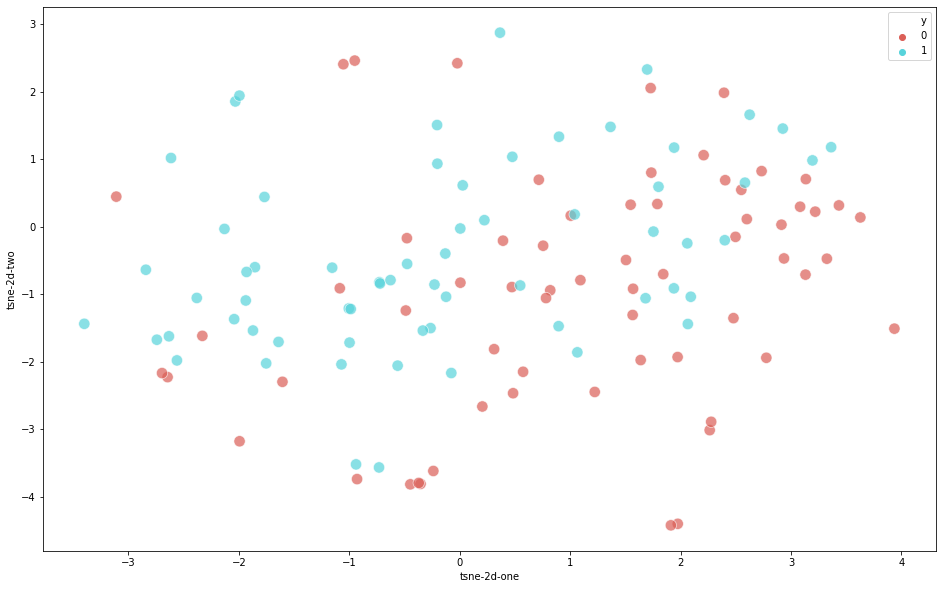

In [30]:
# ... and plot the clusters
# and plot
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=plot_data,
    legend="full",
    alpha=0.7,
    s=128
)
# 

In [31]:
# prepare data for display
print_timestamp(f"start PCA for display")

# scale feature values
X_dimred, y_train = normalise_features(True)
X_dimred['y'] = y_train

# Create a PCA that will retain 99% of the variance
pca = PCA( n_components=2
          , random_state = 42
         #, whiten=True
         )

# run PCA
pca_results = pca.fit_transform(X_dimred)

plot_data = fifa_features.copy()
plot_data['pca-one'] = pca_results[:,0]
plot_data['pca-two'] = pca_results[:,1]
plot_data['y'] = y_train

print_timestamp(f"end PCA for display")

# plot_data.head()


start PCA for display at 04:46:25
end PCA for display at 04:46:25


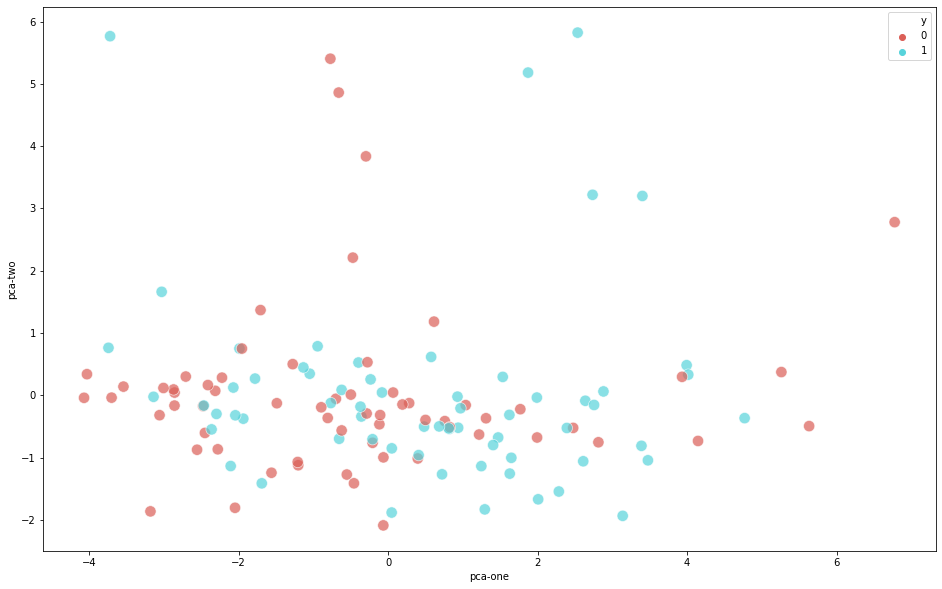

In [32]:
# ... and plot
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=plot_data,
    legend="full",
    alpha=0.7,
    s=128
)


In [33]:
# check if KernelPCA returns better results
print_timestamp(f"start KernelPCA for display")

X_dimred, y_train = normalise_features(True)
X_dimred['y'] = y_train

# Create a PCA that will retain 99% of the variance
kpca = KernelPCA( n_components = 2
                , random_state = 42
                , kernel = 'rbf'
                , gamma = 0.001 
                )

# Conduct PCA
kpca_results = kpca.fit_transform(X_dimred)

plot_data = fifa_features.copy()
plot_data['kpca-one'] = pca_results[:,0]
plot_data['kpca-two'] = pca_results[:,1]
plot_data['y'] = y_train

print_timestamp(f"end KernelPCA for display")

#plot_data.head()


start KernelPCA for display at 04:46:26
end KernelPCA for display at 04:46:26


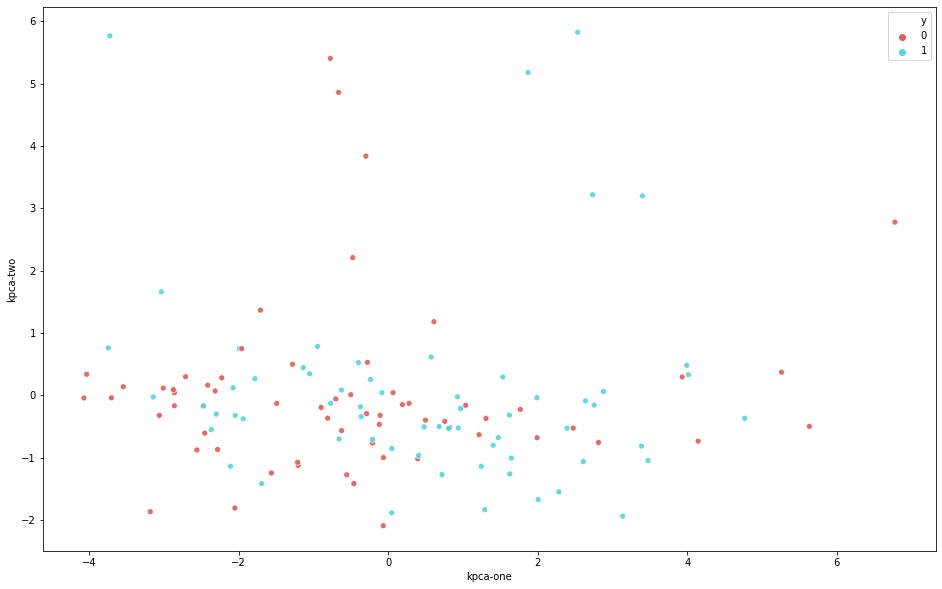

In [34]:
# ... last but not least plot KernelPCA
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="kpca-one", y="kpca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=plot_data,
    legend="full",
    alpha=0.9
)


# Evaluate Model-Agnostic Methods
See if LIME or SHAP is going to be used for verbalisation.
The base ML model is Random Forest

In [35]:
# load models
# using joblib
random_forest = utls.load_model(model_path, 'fifa_skl_rand_forest.pkl')

In [36]:
# load data

# loads Fifa data and applies the model and inserts probability
# Adds game (team, opponent, date)
# 1d-tSNE for plotting
# colour coding: true no: FireBtick, false no: LightCoral, true yes: Navy, false yes: LightSkyBlue
fifa_data, fifa_features, fifa_labels = utls.load_fifa_data_expl( data_path
                                                                , 'FIFA 2018 Statistics.csv'
                                                                , random_forest)
X_fifa, y_fifa = normalise_features(False)

fifa_data.head(1)


,Team,Game,Man of the Match,y_true,y_pred,y_err,motm_prob,colour,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals,tsne-1d
0,Russia,Russia vs Saudi Arabia on 14/06/2018,Yes,1,1,0,0.79,Navy,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0,0.0,-1.193887


In [37]:
# Random Forest feature importance
df = pd.DataFrame({'Features': list(fifa_features.columns),
                'Importance': list(random_forest.feature_importances_)})
df


,Features,Importance
0,Goal Scored,0.388545
1,Ball Possession %,0.031038
2,Attempts,0.072126
3,On-Target,0.052214
4,Off-Target,0.009249
5,Blocked,0.109667
6,Corners,0.063925
7,Offsides,0.009703
8,Free Kicks,0.031538
9,Saves,0.036959


In [38]:
# evaluate loaded models
def evaluate_model(trained_model, model_name):
    # accuracy training
    acc_train, fl_train, cm_train = utls.text_acc_f1_cm( X_fifa 
                                                       , y_fifa
                                                       , trained_model
                                                       , f'{model_name}')
    return acc_train, fl_train, cm_train

# random forest
X_fifa, y_fifa = normalise_features(False)
print(f"RANDOM FOREST")
acc_train_rf, f1_train_rf, cm_train_rf = evaluate_model( random_forest, "'random forest'")
print(f"{acc_train_rf}\n{f1_train_rf}\nconfusion matrix:\n{cm_train_rf}\n")


RANDOM FOREST
accuracy for 'random forest' =  92.19%
f1-score for 'random forest' =  92.75%
confusion matrix:
[[54 10]
 [ 0 64]]



## Bokeh prototype

In [39]:
# interactive Bokeh plot

if run_bokeh:
    output_notebook()
    
    print_timestamp('start Bokeh')
    # Bokeh data format
    source = ColumnDataSource(fifa_data)

    p = figure()

    # circle for each team and match
    p.circle(  x = 'motm_prob'
             , y = 'tsne-1d'
             , color = 'colour'
             , size = 10
             , alpha = 0.8
             , legend = 'Man of the Match'
             , source = source )
    # add legend
    p.legend.title = 'MotM'
    p.legend.location = 'top_center'
    # left has no man of the match, right one does
    class_threshold = Span( location = 0.5
                          , dimension='height'
                          , line_color = 'SlateGrey'
                          , line_alpha = 0.4
                          , line_width = 1)
    p.add_layout(class_threshold)

    # data interaction
    hover = HoverTool( tooltips = [ ('Game', '@Game')
                                  , ('Truth', '@y_true')
                                  , ('Predict', '@y_pred')
                                  , ('Error', '@y_err')
                                  , ('Probability', '@motm_prob')
                                  , ('Man of the Match', '@{Man of the Match}') 
                                  ]
                     )
    p.tools = [hover]

    # ... and show
    show(p)
    

Loading BokehJS ...

start Bokeh at 04:46:26


## Explainers

In [40]:
# game for testing
game_idx = 55 # random.randrange(fifa_features.shape[0])
fifa_data.iloc[[game_idx]]

,Team,Game,Man of the Match,y_true,y_pred,y_err,motm_prob,colour,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals,tsne-1d
55,Mexico,Mexico vs Korea on 23/06/2018,Yes,1,1,0,0.82,Navy,2,59,13,5,6,2,5,0,24,5,89,485,97,7,0,0,0,0,0.0,2.508855


In [41]:
fifa_features.values[game_idx]

array([  2.,  59.,  13.,   5.,   6.,   2.,   5.,   0.,  24.,   5.,  89.,
       485.,  97.,   7.,   0.,   0.,   0.,   0.,   0.])

# Evaluate LIME

In [42]:
# LIME explainer
lime_fifa = LimeTabularExplainer( fifa_features.values
                                , mode="classification" 
                                , feature_names = fifa_features.columns
                                , class_names = ['0', '1']
                                , discretize_continuous = False
                                , random_state = 42)
motm_exp = lime_fifa.explain_instance(fifa_features.values[86], random_forest.predict_proba)

In [43]:
# this is the LIME visual output
exp = lime_fifa.explain_instance(fifa_features.values[game_idx]
                                 , random_forest.predict_proba
                                 , top_labels=1) #, num_features=5
exp.show_in_notebook(show_table=True, show_all=True)


In [44]:
# and the features
lime_features, lime_values = zip(*exp.as_list())
lime_df = pd.DataFrame({'features': lime_features
                       ,'lime_values': lime_values} )
lime_df['abs_values'] = abs(lime_df.lime_values)
lime_df.sort_values(['abs_values'], inplace=True, ascending=False)                            
lime_df.head(None)


,features,lime_values,abs_values
0,Goal Scored,0.174371,0.174371
1,Corners,0.039549,0.039549
2,On-Target,0.032702,0.032702
3,Free Kicks,0.032427,0.032427
4,Pass Accuracy %,0.027028,0.027028
5,Distance Covered (Kms),0.018725,0.018725
6,Offsides,0.008791,0.008791
7,Yellow Card,-0.007615,0.007615
8,Ball Possession %,0.006971,0.006971
9,Saves,0.003580,0.003580


# Evaluate SHAP

In [45]:
# shap
shap_explainer = shap.TreeExplainer(random_forest)
shap.initjs()

In [46]:
# Use SHAP values to show the effect of each feature of a given team and game
# explain one prediction

# get the data
observation = fifa_features.iloc[game_idx].astype(float) 

# model prediction
model_prediction = random_forest.predict(fifa_features.iloc[[game_idx]])[0]

# determine shap values for the observation
shap_values = shap_explainer.shap_values(observation)

# model prediction and probabilities
print(f"model prediction: {random_forest.predict(fifa_features.iloc[[game_idx]])}")
print(f"class probabilities: {random_forest.predict_proba(fifa_features.iloc[[game_idx]])}")
print()

# source:
# https://shap.readthedocs.io/en/latest/index.html?highlight=expected_value#explainers    
# For models with a single output this returns 
# a matrix of SHAP values (# samples x # features). 
# Each row sums to the difference between the model output for that sample 
# and the expected value of the model output 
# (which is stored in the expected_value attribute of the explainer when it is constant). 
# For models with vector outputs this returns a list of such matrices, one for each output.

# Shap prediction for observation and both classes
for i in [0,1]:
    base = shap_explainer.expected_value[i]
    vals = shap_values[i].sum()
    print(f"Class {i}: Base = {base:.3f}, Shap = {vals:.3f}, Probability = {base+vals:.3f}")

model prediction: [1]
class probabilities: [[0.17731667 0.82268333]]

Class 0: Base = 0.500, Shap = -0.323, Probability = 0.177
Class 1: Base = 0.500, Shap = 0.323, Probability = 0.823


In [47]:
# display explanation for this prediction
shap.force_plot(shap_explainer.expected_value[model_prediction], shap_values[model_prediction], observation)

In [48]:
shap_df = pd.DataFrame({'features': list(fifa_features.columns)
                       ,'shap_values': list(shap_values[model_prediction])})
shap_df['abs_values'] = abs(shap_df.shap_values)
shap_df.sort_values(['abs_values'], inplace=True, ascending=False)                            
shap_df.head(None)

,features,shap_values,abs_values
0,Goal Scored,0.135250,0.135250
10,Pass Accuracy %,0.043887,0.043887
8,Free Kicks,0.039015,0.039015
2,Attempts,0.038653,0.038653
6,Corners,0.028014,0.028014
5,Blocked,0.025821,0.025821
3,On-Target,0.016404,0.016404
11,Passes,-0.011185,0.011185
14,Yellow Card,0.010077,0.010077
7,Offsides,-0.005236,0.005236


# Pre-Compute Counterfactuals

In [49]:
# feature data distribution to determine the values per feature for perturbation
class_label = 1
num_cols = [col for col in fifa_features.columns
               if (fifa_features[col].dtype == np.int64 or fifa_features[col].dtype == np.float64)]
d = fifa_data[fifa_data.y_true == class_label].describe()
d = fifa_data.describe()
print
d.loc[['min', 'max'],num_cols]

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals
min,0.0,25.0,3.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,67.0,189.0,80.0,5.0,0.0,0.0,0.0,0.0,0.0
max,6.0,75.0,26.0,12.0,11.0,10.0,11.0,5.0,26.0,9.0,94.0,1137.0,148.0,25.0,6.0,1.0,1.0,4.0,1.0


In [50]:
# based on the cell above declare a dictionary that holds a perturbation values per feature
num_cols = [col for col in fifa_features.columns
               if (fifa_features[col].dtype == np.int64 or fifa_features[col].dtype == np.float64)]
range_dict = {'Goal Scored': range(7),
              'Ball Possession %': range(25,76,5), 
              'Attempts': range(3,27,2), 
              'On-Target': range(13), 
              'Off-Target': range(1,12), 
              'Blocked': range(11), 
              'Corners': range(12), 
              'Offsides': range(6), 
              'Free Kicks': range(5,28,2), 
              'Saves': range(10), 
              'Pass Accuracy %': range(67, 97, 3), 
              'Passes': range(180, 1200, 60), 
              'Distance Covered (Kms)': range(80, 155, 7), 
              'Fouls Committed': range(5, 26, 2), 
              'Yellow Card': range(7), 
              'Yellow & Red': range(2), 
              'Red': range(2), 
              'Goals in PSO': range(5), 
              'Own goals': range(2)}

for feature in num_cols:
    print(f"{feature}: {list(range_dict[feature])}")

Goal Scored: [0, 1, 2, 3, 4, 5, 6]
Ball Possession %: [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
Attempts: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
On-Target: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Off-Target: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Blocked: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Corners: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Offsides: [0, 1, 2, 3, 4, 5]
Free Kicks: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]
Saves: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Pass Accuracy %: [67, 70, 73, 76, 79, 82, 85, 88, 91, 94]
Passes: [180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140]
Distance Covered (Kms): [80, 87, 94, 101, 108, 115, 122, 129, 136, 143, 150]
Fouls Committed: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
Yellow Card: [0, 1, 2, 3, 4, 5, 6]
Yellow & Red: [0, 1]
Red: [0, 1]
Goals in PSO: [0, 1, 2, 3, 4]
Own goals: [0, 1]


In [51]:
# test: list the most important features per prediction
def debug_template(text, lout):
    '''console debug information with switch''' 
    if lout:
        print(text)    

def explain_prediction(game_index, n_lines = 5, l_out = False):
    # get data
    observation = fifa_features.iloc[game_index].astype(float) 

    # model prediction
    model_prediction = random_forest.predict(fifa_features.iloc[[game_index]])[0].astype(int)

    # determine shap values for the observation
    shap_values = shap_explainer.shap_values(observation)

    # collect data for explanation
    shap_df = pd.DataFrame({'features': list(fifa_features.columns)
                           ,'feature_values': fifa_features.iloc[game_index].values.astype(int) # ensures the correct sign
                           ,'shap_values': list(shap_values[model_prediction])})
    shap_df['abs_values'] = abs(shap_df.shap_values)
      
    # generate the explanation 
    ignore_small_shaps = True

    # list of supporting features
    expl_features = []

    # sort by absolute shap value, i.e. feature importance
    shap_df.sort_values(['abs_values'], inplace=True, ascending=False)

    # use shap expected value as the base-line
    class_prob = shap_explainer.expected_value[1 - model_prediction]

    # iterate over the rows
    shap_len = shap_df.shape[0]
    idx = 0
    support_count = 1

    # read shap values for features
    while idx < shap_len:
        # extract feature name and value
        feature_name = shap_df.iloc[idx][0]
        feature_value = shap_df.iloc[idx][1]
        debug_template(f"{idx} feature '{feature_name}', value {feature_value}", l_out)
        if  support_count > 5 and class_prob > 0.5: #and idx > n_lines-1:
            debug_template(f"  - breaking, sup-lines = {support_count}, lines={idx}, class={class_prob}", l_out)
            break
        if ignore_small_shaps and shap_df.iloc[idx][3] < 0.01 and class_prob > 0.5:
            debug_template(f"  - breaking, shap value too small = {shap_df.iloc[idx][3]}", l_out)
            break

        # the shap values have to sum up to >50% probability for the predicted class
        shap_prob = shap_df.iloc[idx][2]
        class_prob += shap_prob
        debug_template(f"  shap={shap_prob}, class={class_prob}", l_out)

        # supporting or opposing text?
        if shap_prob > 0:
            expl_features.append(feature_name)  
            support_count += 1  
        idx += 1
    
    return expl_features 

for i in range(1,8): #fifa_features.shape[0]): 
    expl_features = explain_prediction(i, False)
    print(expl_features)    

print(expl_features)
print_timestamp('done')


['Goal Scored', 'Attempts', 'On-Target', 'Passes', 'Saves']
['Goal Scored', 'Attempts', 'On-Target', 'Corners', 'Pass Accuracy %']
['Goal Scored', 'Corners', 'Attempts', 'Pass Accuracy %', 'Passes']
['Goal Scored', 'On-Target', 'Passes', 'Free Kicks']
['Goal Scored', 'Distance Covered (Kms)', 'Free Kicks', 'On-Target', 'Blocked']
['Goal Scored', 'Distance Covered (Kms)', 'Pass Accuracy %', 'Blocked']
['Goal Scored', 'Attempts', 'Pass Accuracy %', 'Passes', 'Corners']
['Goal Scored', 'Attempts', 'Pass Accuracy %', 'Passes', 'Corners']
done at 04:46:27


In [52]:
# find counterfactuals
# 1. For each observation i predict the class (the fact), 
#    determine the opposite class (the foil), and list the n most important features.
# 2. Using the data for this observation i, 
#    create a local data set by perturbing the values of the most important features. 
#    The new feature values are based on the distribution of the training data set. To keep the permutations manageable the count of permuted values for each feature are limited.
# 3. Predict all local observations, and only consider instances of class foil.
# 4. Use a distance function to find the ’closest’ counter-factual to this observation. 
#    Here: euclidean distance with normalised features.
scaler = StandardScaler()

def find_counterfactual(i):
    # for each observation do:
    
    # get the most important features
    expl_features = explain_prediction(i, False)
    
    # find the permutation ranges
    permutate_features = [list(range_dict[f]) for f in expl_features]

    # permute the relevant features, source:
    # https://stackoverflow.com/questions/798854/all-combinations-of-a-list-of-lists
    feature_combinations = list(itertools.product(*permutate_features))
    feature_combinations
    
    # create the local dataset: DataFrame from dictionary
    # initialise dictionary: key = feature name, value = empty list
    perm_f_dict = {feat_name: [] for feat_name in expl_features}

    # add the permuted values to the dictionary key
    for fidx, feature in enumerate(expl_features):
        for f_tuple in feature_combinations:
            perm_f_dict[feature].append(f_tuple[fidx])

    # DataFrame with local, perturbed dataset
    df_perturb = pd.DataFrame(perm_f_dict)
    df_perturb.shape[0] - 1
    
    # fact and foil
    cf_class = 1 - int(fifa_data.iloc[[i],[4]].values[0])
    game_perturb = pd.DataFrame()
    # copy the row for the observation
    game_perturb  = fifa_features.iloc[[i]].astype(float).copy() 
    # we need as many rows as we have perturbations
    game_perturb = game_perturb.append([game_perturb] * (df_perturb.shape[0] - 1), ignore_index=True)
    # copy the perturbed values for the 5 most important features
    game_perturb[expl_features] = df_perturb

    # run the model in the local dataset
    pred = pd.DataFrame(random_forest.predict(game_perturb))
    # probabilities and prediction
    pred['y_proba'] = pd.DataFrame(random_forest.predict_proba(game_perturb))[cf_class]
    pred.columns = ['y_pred', 'y_proba']
    game_perturb['y_pred'] = pred['y_pred']
    game_perturb['y_proba'] = pred['y_proba']

    # cf_class (counterfactual class) is the foil
    # from the local dataset, only keep observations of class foil 
    # that have been predicted with probability > 65%
    game_perturb = game_perturb[((game_perturb.y_pred==cf_class) & (game_perturb.y_proba>0.65))].copy()
    game_obs = fifa_features.iloc[[i]].astype(float).copy() 
    game_obs['y_pred'] = float((1 - cf_class))
    game_obs['y_proba'] = 1
    game_perturb = game_obs.append(game_perturb, ignore_index=True)
    game_perturb.head()
    
    # for the 'foil' observations calculate the euclidian distance on normalise values
    # which columns?
    scaled_features = ['y_pred', 'y_proba'] + expl_features
    game_perturb = game_perturb[scaled_features].copy()
    # actually add columns for the scaled features
    scaled_features = [f"scale {f}" for f in expl_features]
    game_perturb[scaled_features] = game_perturb[expl_features]
    game_perturb[scaled_features] = scaler.fit_transform(game_perturb[scaled_features])
    # this is the original observation of class fact from which we will measure the distance
    point = game_perturb.loc[0, scaled_features]
    # good old Euclid
    game_perturb['euclid'] = game_perturb[scaled_features].sub(np.array(point)).pow(2).sum(1).pow(0.5)
    # and sort by distance ascending
    game_perturb.sort_values(['euclid', 'y_proba'], ascending =  [True, False], inplace = True)
    game_perturb.reset_index(drop=True, inplace=True)

    # game_perturb.head()
    
    # this is the observation, clearly marked as type 'observation'
    counterfactual = fifa_data.iloc[[i]].copy() 
    counterfactual['type'] = 'observation'
    # do we even have a conterfactual?
    if game_perturb.shape[0] > 0:
        # we do indeed, mark as type 'c.f. euclid'
        cpy = counterfactual.copy()
        cpy.reset_index(drop=True, inplace=True)
        cf_features = game_perturb.loc[[1], expl_features]
        cf_features.reset_index(drop=True, inplace=True)
        cpy[expl_features] = cf_features[expl_features]
        cpy.type = 'c.f. euclid'
        counterfactual = counterfactual.append(cpy, ignore_index = True)
    
    # this is fact and closest (as per euclidian distance) foil
    return counterfactual

# start log
print_timestamp('start search counterfactual')

# seed the dataframe with the first team / game
all_cf = find_counterfactual(0)

# add counterfactuals for all other games
for i in range(1,128):
    cf = find_counterfactual(i)
    all_cf = all_cf.append(cf, ignore_index = True)

# end log    
print_timestamp('end search counterfactual\n')

# display
all_cf.head(None)


start search counterfactual at 04:46:27
end search counterfactual
 at 04:58:32


,Team,Game,Man of the Match,y_true,y_pred,y_err,motm_prob,colour,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals,tsne-1d,type
0,Russia,Russia vs Saudi Arabia on 14/06/2018,Yes,1,1,0,0.79,Navy,5.0,40.0,13.0,7.0,3.0,3.0,6.0,3.0,11.0,0.0,78.0,306.0,118.0,22.0,0.0,0,0,0,0.0,-1.193887,observation
1,Russia,Russia vs Saudi Arabia on 14/06/2018,Yes,1,1,0,0.79,Navy,5.0,40.0,13.0,7.0,3.0,9.0,6.0,3.0,11.0,0.0,78.0,306.0,118.0,22.0,0.0,0,0,0,0.0,-1.193887,c.f. euclid
2,Saudi Arabia,Saudi Arabia vs Russia on 14/06/2018,No,0,0,0,0.00,FireBrick,0.0,60.0,6.0,0.0,3.0,3.0,2.0,1.0,25.0,2.0,86.0,511.0,105.0,10.0,0.0,0,0,0,0.0,-0.291295,observation
3,Saudi Arabia,Saudi Arabia vs Russia on 14/06/2018,No,0,0,0,0.00,FireBrick,1.0,60.0,5.0,2.0,3.0,3.0,2.0,1.0,25.0,2.0,86.0,600.0,105.0,10.0,0.0,0,0,0,0.0,-0.291295,c.f. euclid
4,Egypt,Egypt vs Uruguay on 15/06/2018,No,0,0,0,0.00,FireBrick,0.0,43.0,8.0,3.0,3.0,2.0,0.0,1.0,7.0,3.0,78.0,395.0,112.0,12.0,2.0,0,0,0,0.0,-2.848765,observation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,England,England vs Belgium on 14/07/2018,No,0,0,0,0.19,FireBrick,1.0,55.0,15.0,5.0,7.0,3.0,5.0,0.0,11.0,2.0,92.0,698.0,110.0,5.0,2.0,0,0,0,0.0,2.237926,c.f. euclid
252,France,France vs Croatia on 15/07/2018,Yes,1,1,0,0.74,Navy,4.0,39.0,8.0,6.0,1.0,1.0,2.0,1.0,14.0,1.0,75.0,271.0,99.0,14.0,2.0,0,0,0,1.0,-1.765084,observation
253,France,France vs Croatia on 15/07/2018,Yes,1,1,0,0.74,Navy,4.0,39.0,8.0,3.0,1.0,1.0,2.0,1.0,14.0,1.0,75.0,271.0,94.0,14.0,2.0,0,0,0,1.0,-1.765084,c.f. euclid
254,Croatia,Croatia vs France on 15/07/2018,No,0,1,1,0.57,LightSkyBlue,2.0,61.0,15.0,3.0,8.0,4.0,6.0,1.0,15.0,3.0,83.0,547.0,100.0,13.0,1.0,0,0,0,0.0,2.222225,observation


In [53]:
# save the file for use in the explanation app
all_cf.to_csv(os.path.join(data_path, 'counter_factuals_euclid.csv'), index=False)


### ... the end

In [54]:
# the end
print_timestamp('all done, goodbye')


all done, goodbye at 04:58:32
